# Notes
- incorrect because delay parameters have been used to predict
- incorrect because class is not balanced
- incorrect because one hot encoding is used in entire dataset

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
### download the db from link in readme
db_path = "../../dbs/delays_new.db"

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [4]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = (df.ArrDelay>15).astype(int)
    
    
    df = df[['Year',
     'Month',
     'DayofMonth',
     'DayOfWeek',
     'IATA_CODE_Reporting_Airline',
     'OriginAirportID',
     'DestAirportID',
     'DepDelay',
     'AirTime',
     'Distance',
     'CarrierDelay',
     'WeatherDelay',
     'NASDelay',
     'SecurityDelay',
     'LateAircraftDelay']]
    

    
    # One-hot encode nominal feature columns
    X = onehot_encode(
        df,
        column_dict={
            'IATA_CODE_Reporting_Airline': 'AL',
            'OriginAirportID': 'OA',
            'DestAirportID': 'DA',
            'Year': 'Y',
            'Month': 'M',
            'DayofMonth': 'DM',
            'DayOfWeek': 'DW'
        }
    )
    

    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
   
    return X_train, X_test, y_train, y_test

In [6]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [7]:
sample_query = \
    """
        select 
         *
        from 
          delay 
        where 
          year= 2019
          and Cancelled = 0
          and Airtime > 0
        limit 20000
    """

connection = create_connection(db_path)
data =  execute_query(connection, sample_query)

In [8]:
data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,...,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2019,1,3,31,7,2019-03-31,20378,YV,N87303,6061,...,112,111,81,1,498,0,0,0,0,31
1,2019,1,3,31,7,2019-03-31,20378,YV,N510MJ,6062,...,91,78,61,1,441,0,0,0,0,0
2,2019,1,3,31,7,2019-03-31,20378,YV,N510MJ,6062,...,111,110,79,1,441,0,0,0,0,0
3,2019,1,3,31,7,2019-03-31,20378,YV,N86336,6063,...,103,104,72,1,542,0,0,52,0,0
4,2019,1,3,31,7,2019-03-31,20378,YV,N509MJ,6064,...,114,124,89,1,542,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2019,4,12,2,1,2019-12-02,20304,OO,N924SW,5087,...,76,65,49,1,283,233,0,0,0,0
19996,2019,4,12,2,1,2019-12-02,20304,OO,N857AS,5088,...,74,85,47,1,222,0,0,11,0,40
19997,2019,4,12,2,1,2019-12-02,20304,OO,N915SW,5089,...,75,63,31,1,157,87,0,0,0,50
19998,2019,4,12,2,1,2019-12-02,20304,OO,N983SW,5090,...,72,87,46,1,260,0,0,0,0,0


In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [10]:
X_train

,DepDelay,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,AL_9E,AL_AA,...,M_4,M_8,M_12,DM_1,DM_2,DM_28,DM_31,DW_1,DW_3,DW_7
0,-0.243022,1.233724,1.057492,-0.141692,-0.039053,-0.163675,-0.015488,-0.201543,-0.202792,-0.386312,...,-0.723002,-0.822707,2.082643,-0.723002,2.082643,-0.822707,-0.265210,0.940482,-0.822707,-0.265210
1,-0.300723,-0.065615,0.004174,-0.141692,-0.039053,-0.163675,-0.015488,-0.201543,-0.202792,-0.386312,...,-0.723002,1.215499,-0.480159,-0.723002,-0.480159,1.215499,-0.265210,-1.063284,1.215499,-0.265210
2,-0.300723,-0.397668,-0.389749,-0.141692,-0.039053,-0.163675,-0.015488,-0.201543,-0.202792,-0.386312,...,-0.723002,1.215499,-0.480159,-0.723002,-0.480159,1.215499,-0.265210,-1.063284,1.215499,-0.265210
3,-0.339190,-0.700846,-0.691186,-0.141692,-0.039053,-0.163675,-0.015488,-0.201543,-0.202792,-0.386312,...,-0.723002,-0.822707,2.082643,-0.723002,2.082643,-0.822707,-0.265210,0.940482,-0.822707,-0.265210
4,-0.300723,-1.004025,-0.968645,-0.141692,-0.039053,-0.163675,-0.015488,-0.201543,-0.202792,-0.386312,...,-0.723002,1.215499,-0.480159,-0.723002,-0.480159,1.215499,-0.265210,-1.063284,1.215499,-0.265210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,-0.281489,3.139420,2.953463,-0.141692,-0.039053,1.102381,-0.015488,-0.201543,-0.202792,-0.386312,...,-0.723002,1.215499,-0.480159,-0.723002,-0.480159,1.215499,-0.265210,-1.063284,1.215499,-0.265210
13996,-0.358423,-0.195548,-0.213340,-0.141692,-0.039053,-0.163675,-0.015488,-0.201543,-0.202792,-0.386312,...,-0.723002,1.215499,-0.480159,-0.723002,-0.480159,1.215499,-0.265210,-1.063284,1.215499,-0.265210
13997,-0.300723,-0.556476,-0.538755,-0.141692,-0.039053,-0.163675,-0.015488,-0.201543,-0.202792,-0.386312,...,1.383122,-0.822707,-0.480159,1.383122,-0.480159,-0.822707,-0.265210,0.940482,-0.822707,-0.265210
13998,-0.300723,-0.874092,-0.937817,-0.141692,-0.039053,-0.163675,-0.015488,-0.201543,-0.202792,-0.386312,...,-0.723002,-0.822707,-0.480159,-0.723002,-0.480159,-0.822707,3.770596,-1.063284,-0.822707,3.770596


In [11]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

/Users/ayushsubedi/Desktop/learn/fp/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Test Accuracy: 99.25%


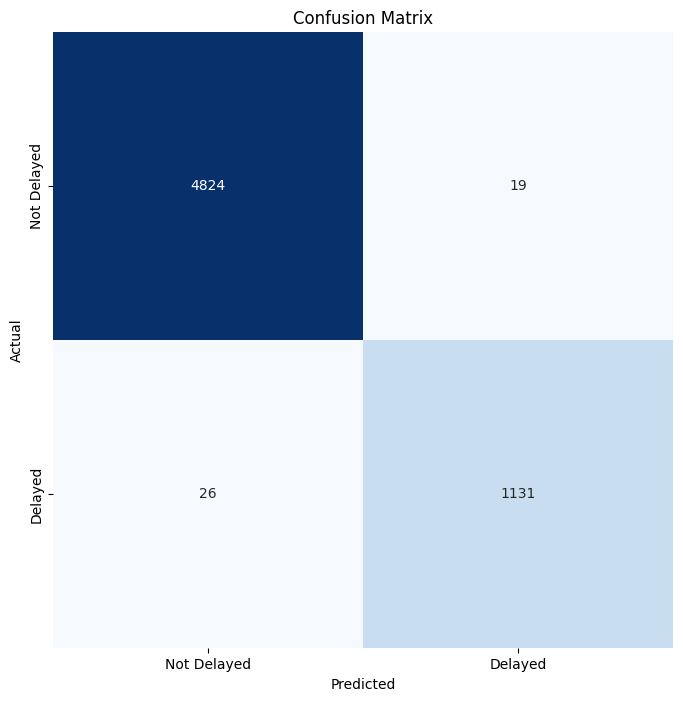

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.99      1.00      1.00      4843
     Delayed       0.98      0.98      0.98      1157

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



In [12]:
evaluate_model(clf, X_test, y_test)